In [5]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from plotting_constants import gif_length, fps, carrier_colors

In [18]:
day = '2024-03-21'
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'bmus_prepared.csv',
    index_col=0,
    )

bmus = bmus.loc[bmus['lat'] != 'distributed']

bmus['lat'] = bmus['lat'].apply(lambda x: np.around(float(x), 4))
bmus['lon'] = bmus['lon'].apply(lambda x: np.around(float(x), 4))

# bmus


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pypsa

def create_aggregated_timeseries(network, carrier_colors):
    ac_buses = network.buses.index[network.buses.carrier == "AC"]
    gen = network.generators[network.generators.bus.isin(ac_buses)]
    if not gen.empty:
        gen_ts = network.generators_t.p[gen.index]
        gen_ts_grouped = gen_ts.groupby(gen.carrier, axis=1).sum()

    else:
        gen_ts_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])
    stor = network.storage_units[network.storage_units.bus.isin(ac_buses)]
    if not stor.empty:
        stor_ts = network.storage_units_t.p[stor.index]
        stor_ts_grouped = stor_ts.groupby(stor.carrier, axis=1).sum()
    else:
        stor_ts_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])
    links = network.links
    link_contrib = pd.DataFrame(0, index=network.snapshots, columns=links.index)
    for link in links.index:
        bus0 = links.loc[link, "bus0"]
        bus1 = links.loc[link, "bus1"]
        p = network.links_t.p0[link]

        if bus0 in ac_buses and bus1 not in ac_buses:
            link_contrib[link] = -p
        elif bus1 in ac_buses and bus0 not in ac_buses:
            link_contrib[link] = p

    if not links.empty:
        if 'carrier' in links.columns:
            link_contrib_grouped = link_contrib.groupby(links.carrier, axis=1).sum()
        else:
            link_contrib.columns = ["interconnector"] * len(link_contrib.columns)
            link_contrib_grouped = link_contrib.groupby(axis=1, level=0).sum()
    else:
        link_contrib_grouped = pd.DataFrame(0, index=network.snapshots, columns=[])

    all_carriers = list(set(gen_ts_grouped.columns).union(stor_ts_grouped.columns).union(link_contrib_grouped.columns))

    combined = pd.DataFrame(0, index=network.snapshots, columns=all_carriers)
    for df in [gen_ts_grouped, stor_ts_grouped, link_contrib_grouped]:
        for col in df.columns:
            combined[col] = combined[col] + df[col]

    sorted_cols = [carrier for carrier in carrier_colors.keys() if carrier in combined.columns]
    remaining = [carrier for carrier in combined.columns if carrier not in sorted_cols]

    combined = combined[sorted_cols + remaining].mul(1e-3)

    sort_order = combined.var().sort_values().index
    neg = combined[combined <= 0].replace(np.nan, 0)[sort_order]
    pos = combined[combined > 0].replace(np.nan, 0)[sort_order]

    return pos, neg


def animate_generation_mix(
        network,
        carrier_colors,
        gif_length_sec=10,
        fps=25,
        output_filename="generation_mix.gif"
        ):

    pos, neg = create_aggregated_timeseries(network, carrier_colors)

    x_times = (pos.index - pos.index[0]).total_seconds() / 3600.0
    carriers = pos.columns.tolist()

    y_data_pos = [pos[carrier].values for carrier in carriers]
    y_data_neg = [neg[carrier].values for carrier in carriers]

    fig, ax = plt.subplots(figsize=(12, 4))

    # ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Power (GW)")
    # ax.set_title("Generation Mix Over a Day")

    colors = [carrier_colors.get(carrier, None) for carrier in carriers]

    stack_kwargs = {
        'linewidth': 0.5,
        'edgecolor': 'black',
        'alpha': 0.9,
    }

    ax.stackplot(x_times, y_data_pos, labels=carriers, colors=colors, **stack_kwargs)
    ax.stackplot(x_times, y_data_neg, labels=carriers, colors=colors, **stack_kwargs)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)

    # ax.legend(loc="upper left")
    ax.set_xlim(0, 23)
    vline = ax.axvline(x=0, color="k", linestyle="--", linewidth=2)
    total_frames = int(gif_length_sec * fps)
    x_positions = np.linspace(0, 24, total_frames)

    def update(frame):
        vline.set_xdata([x_positions[frame]])
        return [vline]

    # plt.show()
    # import sys
    # sys.exit()

    ani = animation.FuncAnimation(fig, update, frames=total_frames, blit=True, interval=1000/fps)
    ani.save(output_filename, writer="pillow", fps=fps)
    plt.close(fig)
    print(f"Saved GIF to {output_filename}")


In [72]:
n = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)

output_filename = "generation_mix.gif"

animate_generation_mix(
    n,
    carrier_colors,
    gif_length_sec=gif_length,
    fps=fps,
    output_filename=output_filename,
    )

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
C:\Users\lukas\AppData\Local\Temp\ipykernel_26096\224541075.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gen_ts_grouped = gen_ts.groupby(gen.carrier, axis=1).sum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_26096\224541075.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  stor_ts_grouped = stor_ts.groupby(stor.carrier, axis=1).sum()
C:\Users\lukas\AppData\Local\Temp\ipykernel_26096\224541075.py:36: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  link_contrib_grouped = link_contrib.groupby(links.carrier, axis=1).sum()
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


Saved GIF to generation_mix.gif


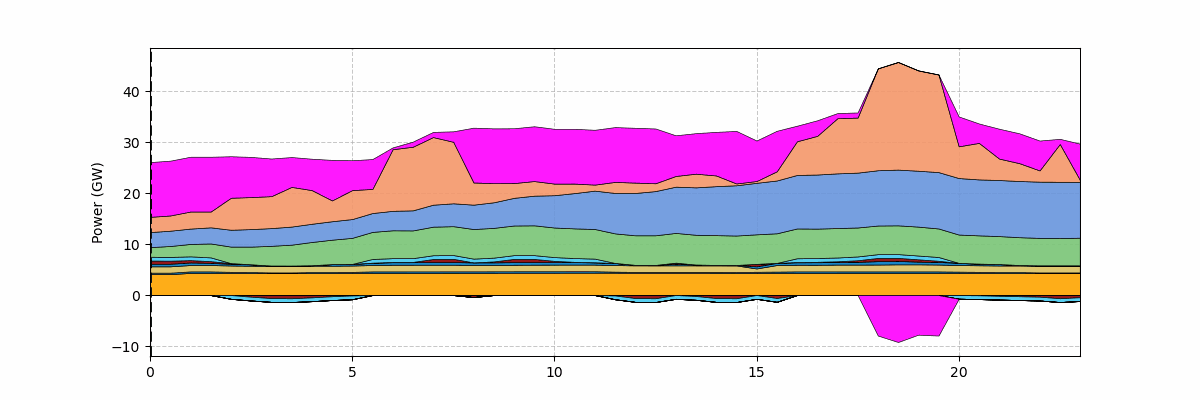

In [73]:
from IPython.display import Image, display
display(Image(filename=output_filename))